In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers

In [7]:
dataset_path = "final_data"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "validation",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)

Found 1895 files belonging to 16 classes.
Using 1516 files for training.
Found 1895 files belonging to 16 classes.
Using 379 files for validation.


In [ ]:

model = models.Sequential([
    
    layers.Conv1D(64, kernel_size=80, strides=16, activation="relu", input_shape=(48000, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    
    
    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    

    layers.Conv1D(256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.3),  

  
    layers.Conv1D(512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.4),  

    
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),  
    layers.Dropout(0.5),  
    layers.Dense(16, activation="softmax")  
])


In [9]:

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


c:\Users\Dr.Laptop\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [10]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,

)

model.save("final_model.keras")

Epoch 1/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 243s 622ms/step - accuracy: 0.2365 - loss: 4.4319 - val_accuracy: 0.1108 - val_loss: 4.6845
Epoch 2/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 211s 558ms/step - accuracy: 0.4513 - loss: 2.8073 - val_accuracy: 0.7784 - val_loss: 1.5248
Epoch 3/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 206s 543ms/step - accuracy: 0.5409 - loss: 2.1113 - val_accuracy: 0.8047 - val_loss: 1.2082
Epoch 4/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 197s 520ms/step - accuracy: 0.6132 - loss: 1.7835 - val_accuracy: 0.8602 - val_loss: 0.9930
Epoch 5/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 188s 496ms/step - accuracy: 0.6487 - loss: 1.5337 - val_accuracy: 0.8232 - val_loss: 0.9654
Epoch 6/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 218s 575ms/step - accuracy: 0.6924 - loss: 1.3175 - val_accuracy: 0.8522 - val_loss: 0.8473
Epoch 7/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 211s 557ms/step - accuracy: 0.7134 - loss: 1.3295 - val_accuracy: 0.8707 - val_loss: 0.7845
Epoch 8/20
379/379 ━━━━━━━━━━━━━━━━━━━━ 267s 570ms/step - accuracy: 0.7521 -

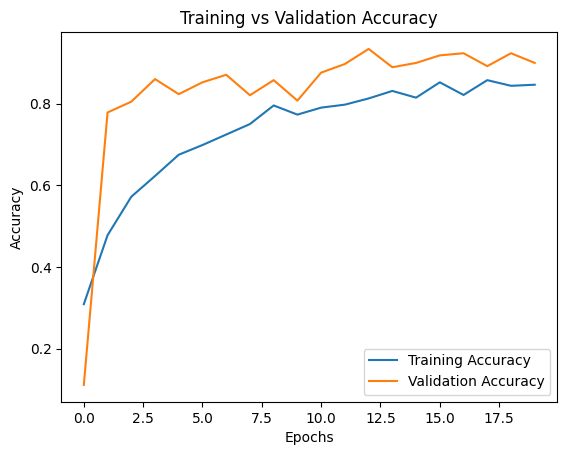

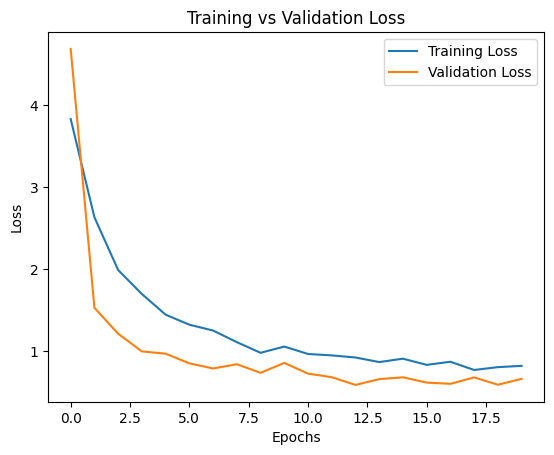

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [16]:
# Make predictions on the validation data
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in validation_data], axis=0)
true_labels = np.argmax(true_labels, axis=1)

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


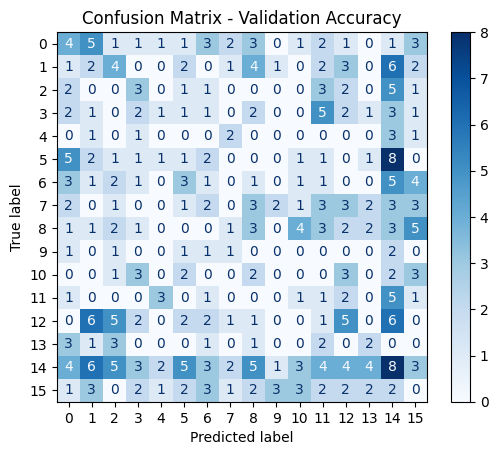

In [17]:
# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Validation Accuracy')
plt.show()

In [ ]:
def predict_audio(audio_path):
    audio, sr = tf.audio.decode_wav(tf.io.read_file(audio_path))
    audio = tf.expand_dims(audio, axis=0)
    audio = tf.keras.preprocessing.sequence.pad_sequences(audio, maxlen=48000, padding="post", truncating="post")
    predictions = model.predict(audio)
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class


audio_path = ""
predicted_class = predict_audio(audio_path)
print(f"Predicted class: {predicted_class}")

NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: your_classmate_audio.wav : The system cannot find the file specified.
; No such file or directory [Op:ReadFile]